In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, SNR_plot, network_sender_receiver
from filters import butter_lowpass
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import joint_train_loop
from DE_Pytorch import DE
from scipy import signal
import scipy
import torchaudio
from scipy.stats import norm

In [6]:
def get_data():

    upsampled = CS.upsample()
    X_tx = torch.Tensor(upsampled).view(1, 1, -1)
    classes = np.array(symbol_set)
    y = symbol_seq
    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X_tx, y

In [21]:
symbol_set = [3, 1, -1, -3] # all symbols that we use
num_symbols = 10000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, beta=0.35)

# Create 1D Convolutional Neural Networks for transmitter and receiver and define optimizer and loss
# Remember to double check padding and general design of NN_tx and NN_rx

Xtrain, ytrain = get_data()
Xtest, ytest = get_data()

NN_tx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64, padding=len(CS.h)-1)) # padding=len(CS.h) - 1
NN_rx = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
params = list(NN_tx.parameters()) + list(NN_rx.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3)

In [ ]:
# Joint train sender and receiver NN using Backpropagation

epoch_losses = joint_train_loop(NN_tx, NN_rx, Xtrain, ytrain, optimizer, criterion, sample_rate=CS.m, 
                                epochs=500, cutoff_freq=0.2, v=True, use_cuda=False, SNRdb=10, plot_iteration=100)

plt.figure(figsize=(13, 8))
plt.plot(epoch_losses.to('cpu'))
plt.show()

In [ ]:
# Evaluate

SNR = 10
joint_decisions = CS.transmission(SNRdb=SNR, mode='joint', joint_cutoff=0.2, model=[NN_tx, NN_rx])
print('Accuracy:', 1 - CS.evaluate(joint_decisions)[1])

In [ ]:
SNRdbs, euclid_er, network_er, NN_er, block_er, joint_er,  error_theory = \
SNR_plot(num_symbols=10000, joint_cutoff=0.3, joint_models=[NN_tx, NN_rx]) #[NN_tx, NN_rx]
                                                                                          

plt.figure(figsize=(18,11))
plt.title('Noise Plot', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRdbs[num:], euclid_er[num:])
#plt.semilogy(SNRdbs[num:], NN_er[num:])
#plt.semilogy(SNRdbs[num:], block_er[num:])
plt.semilogy(SNRdbs[num:], network_er[num:])
plt.semilogy(SNRdbs[num:], joint_er[num:], alpha=1)
plt.semilogy(SNRdbs[num:], error_theory[num:], alpha=1)
legend0 = ['Receiver Network', 'Theory']
legend1 = ['Euclidean', 'Receiver Network', 'Joint Networks', 'Theory']
legend2 = ['Euclidean', 'NN Dec Maker', 'Block', 'Receiver Network', 'Joint Networks', 'Theory']
plt.legend(legend1, fontsize=16)
plt.show()

## Experiment W/ Ideal Low Pass Filter

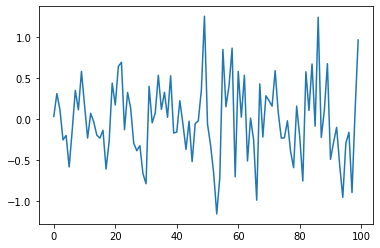

In [22]:
NN_tx = torch.load('../Joint_Models/Sender_cutoff1')
Tx = NN_tx(Xtrain)
plt.plot(Tx.detach()[0][0][:100])
plt.show()

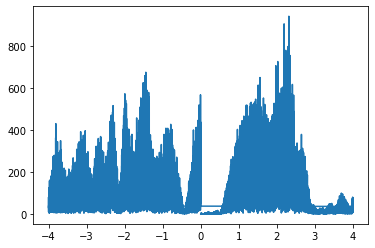

In [28]:
# Calculate Fourier Transform
Tx_freq = torch.fft.rfftn(Tx)
xf = torch.fft.fftfreq(Tx_freq.shape[2], 1/8)
plt.plot(xf.detach(), torch.abs(Tx_freq).detach()[0][0])

/Users/Dragonborn/anaconda/lib/python3.6/site-packages/torch/_tensor.py:680: ComplexWarning: Casting complex values to real discards the imaginary part
  return self.numpy().astype(dtype, copy=False)


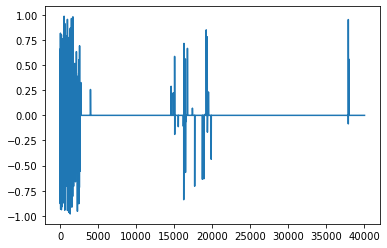

In [29]:
# Setting everything above the cutoff frequency to zero
Tx_freq[torch.abs(Tx_freq) > 1] = 0
plt.plot(Tx_freq.detach()[0][0])

# I use absolute values to cut off. Is that right? And why does rrft return complex values in the first place?

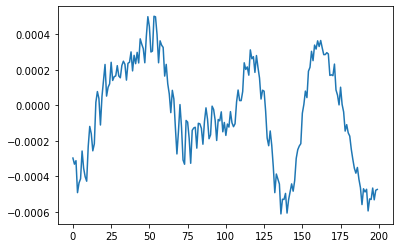

In [30]:
# Use Inverse Fourier Transform to go back to time domain
Tx_back = torch.fft.irfftn(Tx_freq)
plt.plot(Tx_back.detach()[0][0][:200])
